Detected 7 face(s)


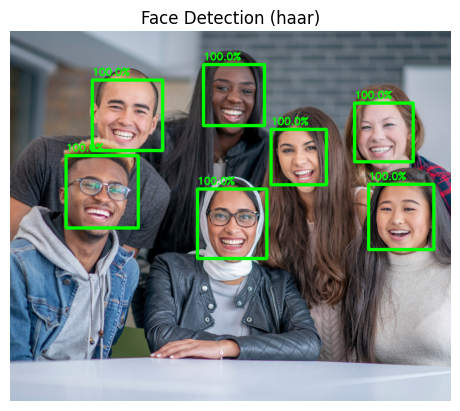

In [16]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Optional: Mediapipe (install with `pip install mediapipe` if not already installed)
try:
    import mediapipe as mp
    mediapipe_available = True
except ImportError:
    mediapipe_available = False
    

# -----------------------------
# Haar Cascade Detection
# -----------------------------
def detect_faces_haar(image):
    cascade_file = 'haarcascade_frontalface_default.xml'
    cascade_path = os.path.join(cv2.data.haarcascades, cascade_file)
    classifier = cv2.CascadeClassifier(cascade_path)

    if classifier.empty():
        raise IOError(f"Unable to load Haar Cascade from {cascade_path}")

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)  # Improve contrast

    bboxes = classifier.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=8,
        minSize=(60, 60)
    )

    filtered = []
    for (x, y, w, h) in bboxes:
        aspect_ratio = w / float(h)
        if 0.75 < aspect_ratio < 1.3:  # Keep only near-square detections
            filtered.append((x, y, w, h))
    return filtered


# -----------------------------
# DNN (Deep Neural Network) Detection
# -----------------------------
def detect_faces_dnn(image):
    modelFile = os.path.join(cv2.data.haarcascades, "../dnn/res10_300x300_ssd_iter_140000.caffemodel")
    configFile = os.path.join(cv2.data.haarcascades, "../dnn/deploy.prototxt")

    if not os.path.exists(modelFile) or not os.path.exists(configFile):
        raise IOError("DNN model files not found. Download deploy.prototxt and res10_300x300_ssd_iter_140000.caffemodel")

    net = cv2.dnn.readNetFromCaffe(configFile, modelFile)

    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0,
                                 (300, 300), (104, 177, 123))
    net.setInput(blob)
    detections = net.forward()

    results = []
    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.6:  # Adjust threshold
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x1, y1, x2, y2) = box.astype("int")
            results.append((x1, y1, x2-x1, y2-y1, confidence))
    return results


# -----------------------------
# Mediapipe Detection
# -----------------------------
def detect_faces_mediapipe(image):
    if not mediapipe_available:
        raise ImportError("Mediapipe not installed")
    
    mp_face = mp.solutions.face_detection
    results_list = []

    with mp_face.FaceDetection(min_detection_confidence=0.6) as face_detection:
        rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = face_detection.process(rgb)

        if results.detections:
            for detection in results.detections:
                bboxC = detection.location_data.relative_bounding_box
                ih, iw, _ = image.shape
                x, y, w, h = int(bboxC.xmin * iw), int(bboxC.ymin * ih), \
                             int(bboxC.width * iw), int(bboxC.height * ih)
                results_list.append((x, y, w, h, detection.score[0]))
    return results_list


# -----------------------------
# Main Script
# -----------------------------
if __name__ == "__main__":
    image_path = "pexels.png"  # Change to your image path
    image = cv2.imread(image_path)
    if image is None:
        raise IOError(f"Unable to load image {image_path}")

    method = "haar"   # Choose: "haar", "dnn", "mediapipe"

    if method == "haar":
        bboxes = detect_faces_haar(image)
        labeled_bboxes = [(x, y, w, h, 1.0) for (x, y, w, h) in bboxes]

    elif method == "dnn":
        bboxes = detect_faces_dnn(image)
        labeled_bboxes = bboxes

    elif method == "mediapipe":
        bboxes = detect_faces_mediapipe(image)
        labeled_bboxes = bboxes

    else:
        raise ValueError("Unknown method. Use 'haar', 'dnn', or 'mediapipe'.")

    # Convert for plotting
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if len(labeled_bboxes) == 0:
        print("No faces detected")
    else:
        print(f"Detected {len(labeled_bboxes)} face(s)")
        for (x, y, w, h, conf) in labeled_bboxes:
            cv2.rectangle(image_rgb, (x, y), (x+w, y+h), (0, 255, 0), 6)  # Bold green box
            cv2.putText(image_rgb, f"{conf*100:.1f}%", (x, y-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)

    # Show output
    plt.imshow(image_rgb)
    plt.title(f'Face Detection ({method})')
    plt.axis('off')
    plt.show()
